# Definition

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import freud
from scipy.interpolate import interp1d
from scipy import interpolate
from Definition import *
from variables import *
from shapely.geometry import Polygon, Point
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data collection and box size determination

In [31]:
with open('data/Exp_voronoi.pickle', 'rb') as file:
    data = pickle.load(file)
box_size = get_box_size(data)
print('box size = ', box_size)

box size =  [1023.0, 1024.0]


### Choosing the sepcific frames

In [32]:
frames = []
for f in range(initial_frame, len(data)-everyframe, everyframe):
    frames.append(np.array(data[f]))
frames = np.array(frames)
print('number of frames = ', len(frames))

number of frames =  4


### Get clusters and interfacial particles

In [33]:
cluster_frames = []
for frame in frames:
    cluster_frames.append(pick_clusters(frame,box_size, minmum_particle_number_of_cluster))
cluster_frames = np.array(cluster_frames)

In [34]:
interfacial_particles_frames = []
for i, frame in enumerate(cluster_frames):
    interfacial_particles_groups = []
    for group in frame:
        interfacial_particles = group[group[:,2] > voronoi_cutoff]
        interfacial_particles_groups.append(np.array(interfacial_particles))
#     print('No.%s frame has '%i, len(interfacial_particles_groups), 'groups')
    interfacial_particles_frames.append(np.array(interfacial_particles_groups))
interfacial_particles_frames = np.array(interfacial_particles_frames)

### Sort interfacial particles

In [35]:
sorted_particles_frames = []
for frame in interfacial_particles_frames:
    sorted_particles_group = []
    for group in frame:
        sorted_particles = sort_particles(group[:,:2], 95)
        sorted_particles_group.append(np.array(sorted_particles))
#         plt.plot(*sorted_particles.T[:2], '-o', mfc = 'k', ms = 3)
#     plt.show()
    sorted_particles_frames.append(np.array(sorted_particles_group))
sorted_particles_frames = np.array(sorted_particles_frames)

### Get mean interface

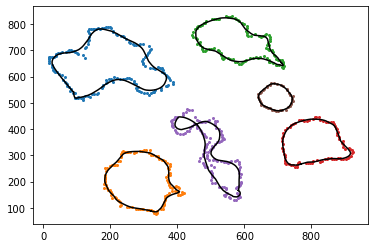

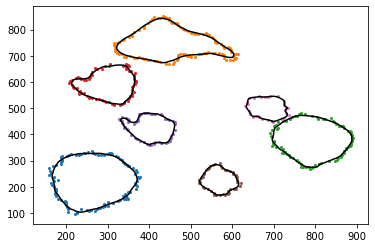

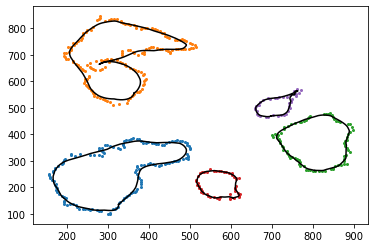

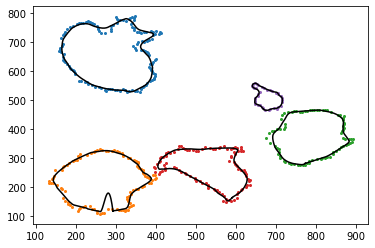

In [44]:
average_number = 10
mean_interface_frames = []
for frame in sorted_particles_frames:
    mean_interface_group = []
    for group in frame:
        mean_inf = get_mean_interpolated_interface(group, 10)
        mean_interface_group.append(np.array(mean_inf))
        plt.plot(*group.T, 'o', ms = 2)
        plt.plot(*mean_inf.T, c = 'k')
    plt.show()
    mean_interface_frames.append(np.array(mean_interface_group))
mean_interfaces_frames = np.array(mean_interface_frames)        

# Main work

### Get smoother area of mean interface

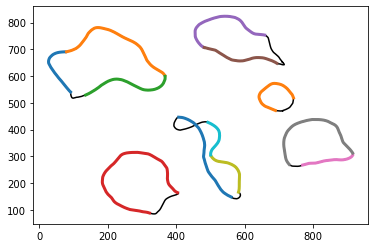

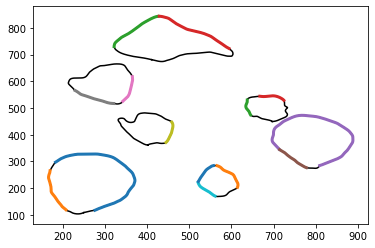

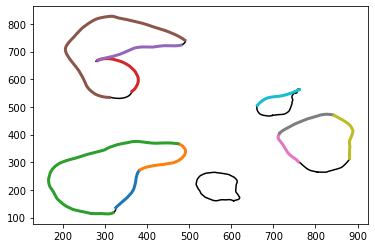

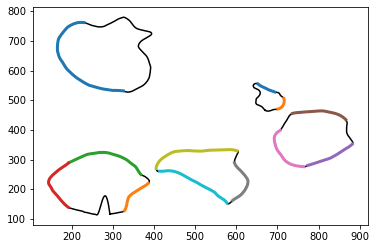

In [42]:
smoother_areas_frames = []
for frame in mean_interface_frames:
    smoother_areas_group = []
    for group in frame:
        areas = pick_smoother_area(group, 0.065)
        areas_bool = [len(a)> 150 for a in areas]
        Areas = areas[areas_bool]
        smoother_areas_group.append(np.array(Areas))
        plt.plot(*group.T, c = 'k')
        for area in Areas:
            plt.plot(*area.T, lw = 3)
    plt.show()
    smoother_areas_frames.append(np.array(smoother_areas_group))
smoother_areas_frames = np.array(smoother_areas_frames)

### Map the interfacial particles to the smoother areas

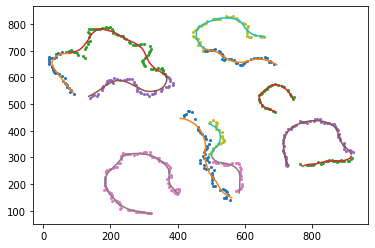

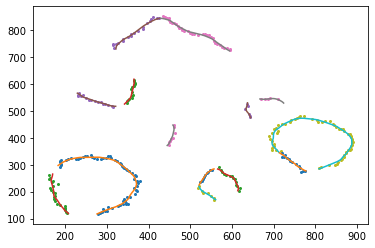

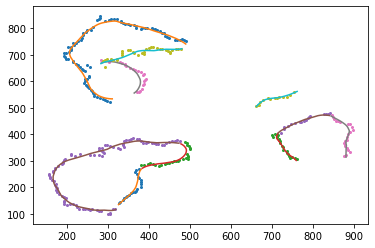

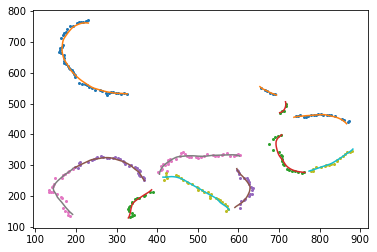

In [43]:
smooth_area_particles_frames = []
for frame_area, frame_mean_interface, frame_particle in zip(smoother_areas_frames, mean_interface_frames, sorted_particles_frames):
    smooth_area_particles_group = []
    for group_mean_interface, group_particle, group_area in zip(frame_mean_interface, frame_particle, frame_area):
        dist = cdist(group_particle, group_mean_interface)
        proj_label = np.argmin(dist, axis = 1)
        proj_mean_interface = group_mean_interface[proj_label]
        smooth_area_particle_area = []
        for area in group_area:
            proj_area_bool = np.isin(np.around(proj_mean_interface, decimals = 3), np.around(area, decimals =3))
            proj_particle = group_particle[proj_area_bool.all(1)]
            smooth_area_particle_area.append(proj_particle)
            plt.plot(*proj_particle.T, 'o', ms = 2)
            plt.plot(*area.T)
        smooth_area_particles_group.append(np.array(smooth_area_particle_area))
    smooth_area_particles_frames.append(np.array(smooth_area_particles_group))
    plt.show()
smooth_area_particles_frames = np.array(smooth_area_particles_frames)
# print(smooth_area_particles_frames)

### Height-Height Correlation Function

In [39]:
total_h = [] #for height PDF
HH_total = [] #for h-h corr function
bins = np.linspace(0,32,15)
for particle_frame, area_frame, mean_frames in zip(smooth_area_particles_frames, smoother_areas_frames, mean_interfaces_frames):
    for particle_group, area_group, mean_group in zip(particle_frame, area_frame, mean_frames):
        polygon = Polygon(mean_group)
        HH_area = []
        for particle_area, mean_area in zip(particle_group, area_group):
            distance = cdist(particle_area, mean_area)
            height = distance.min(axis=1)
            height_sign = np.ones(len(height), dtype = int)
            for i, p in enumerate(particle_area):
                point = Point(p[0], p[1])
                if polygon.contains(point) == True:
                    height_sign[i] *= -1
            total_h.append(height * height_sign)
#             print(mean_area)
#height-height correlation function
            HH = hh_corr_cluster(particle_area, mean_area, height *height_sign, bins)
            HH_total.append(np.array(HH))
total_h = np.array(total_h)
# HH_total = np.array(HH_total)

### Height-Height Correlation plot

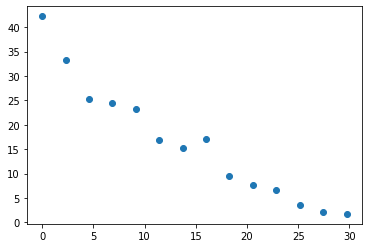

In [40]:
HH_average = np.nanmean(HH_total, axis = 0)
plt.plot(bins[:-1], HH_average, 'o')
# plt.yscale('log')

Number of particles 1490


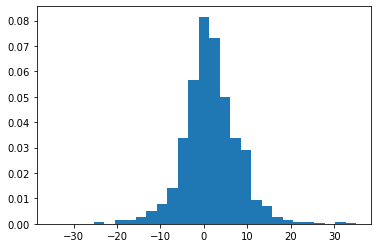

In [41]:
# h_total = np.array([y for y in total_h if 0 not in y.shape])
bins = np.linspace(-35, 35, 30)
h_total = np.concatenate(total_h).ravel()
plt.hist(h_total, bins, density = True)
print('Number of particles', len(h_total))